### Run the trained autoencoder on images and extract latent vectors

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import data_loader as dl
import autoencoder
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA

In [2]:
datadir = 'data/'

load the data

In [3]:
image_data = dl.dataloader_3chan_onedir(datadir, bs=4, shuffle=False, num_workers=4, return_filename=True)
image_shape = image_data.dataset[0][0].shape[1:]

found 122 files


load the autoencoder architecture

In [4]:
model = autoencoder.autoencoder(image_shape)
if torch.cuda.is_available():
    model = model.cuda()

load the weights

In [5]:
model.load_state_dict(torch.load('ae_results/ae_weights.pth', map_location=torch.device('cpu')));

run the autoencoder on the data and split the different categories in separate lists (here different cell types 20CAG and 56CAG)

In [6]:
labels = []
embeds20 = []
embeds56 = []
label_type = []

with torch.no_grad():
    for i1, d in enumerate(iter(image_data)):    
        if torch.cuda.is_available():
            embeds = model(Variable(d[0]).cuda())[1].data.cpu().numpy()
        else:
            embeds = model(Variable(d[0]))[1].data.numpy()
        
        for emb, lab in zip(embeds, d[1]):
            if re.findall('(\d+)CAG',lab)[0] == '20':
                embeds20.append(emb)
            else:
                embeds56.append(emb)
            
    embeds20 = np.vstack(embeds20)
    embeds56 = np.vstack(embeds56)

PCA of the latent vectors

In [7]:
pca = PCA(n_components=2).fit
pca_transform = pca(np.vstack((embeds20,embeds56)))
pca_20 = pca_transform.transform(embeds20)
pca_56 = pca_transform.transform(embeds56)

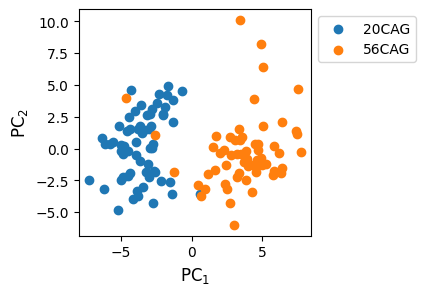

In [8]:
fig,ax = plt.subplots(figsize=(3,3))
ax.scatter(pca_20[:,0], pca_20[:,1])
ax.scatter(pca_56[:,0], pca_56[:,1])
ax.set_xlabel('PC$_1$')
ax.set_ylabel('PC$_2$')
ax.legend(['20CAG', '56CAG'], bbox_to_anchor=(1,1));